# 0. Import packages

First, we import the necessary packages for this exercise.

In [1]:
import xarray as xr 
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs
from datetime import datetime, timedelta
import numpy as np
import cartopy.feature as cfeature

# 1. Open simulation data (done!)

In this exercise we consider the precipitation event from July 2021 which caused massive flooding in the Vesder basin. We have simulated this case in several different configurations. All the output data can be found in the 'data' folder. The data is stored in netCDF-files, which can be easily read as xarray Datasets (see introductory notebook on xarray). Each of the netCDF-files has a structured name `<configuration>_<starttime>_<nhours>_<variable>_<tstart>_<tstop>_<tstep>_regridded.nc` where the different elements have the following meaning:
1. `<configuration>`: This refers to the specific set-up of the model. For some experiments, we can change certain parameters in the model and investigate the impact. For this exercise, however, we will only use the data from the 'baseline'-simulation.
2. `<starttime>`: This refers to the start time of the simulation. By varying the start time, we can create an ensemble of different simulations of the same event (see below). The start time is written in the format of `<year><month><day><hour>`.
3. `<nhours>`: This refers to the number of hours that the simulation has run.
4. `<variable>`: This refers to the variable saved in this file. We use the standard abbreviations from the Climate and Forecast (CF) Metadata Conventions. The ones you will need in these exercises are:
    - *pr*: Precipitation
    - *tas*: Near-Surface Air Temperature
    - *tasmax*: Maximum Near-Surface Air Temperature
    - *tasmin*: Minimum Near-Surface Air Temperature
5. `<tstart>`: This refers to the first time step of the data in the file. This is written in the format of `<year>-<month>-<day>T<hour>`.
6. `<tstart>`: This refers to the last time step of the data in the file. This is written in the format of `<year>-<month>-<day>T<hour>`.
7. `<tstep>`: This refers to the time between subsequent time steps in the data, expressed in seconds. You will see that this is 3600 s for all files (so the data has an hourly resolution).
8. `regridded`: This refers to the fact that the data has been regridded from the orginal coordinate reference system (CRS) to a latitude-longitude reference system. This makes the data easier to work with.
9. `.nc`: This extension denotes the fact that this is a netCDF-file.

Let's start by opening a file and loading in the data! Load in the precipitation data corresponding to the baseline simulation which started at midnight of 1 July 2021. You can use the xarray function `open_dataset` ([documentation](https://docs.xarray.dev/en/stable/generated/xarray.open_dataset.html)) **open_mfdataset??** Save this dataset as `ds` and inspect its contents by printing `ds` or simply running a cell which ends with `ds`. The following questions/tasks will help you along:
- What are the dimensions of the data? Where can you find information about these dimensions?
- First consider the spatial dimensions. What are the units? What is the resolution? Convert this to (kilo)metres. Use the fact that the radius of the Earth is 6371 km.
- Next, consider the attributes of the variable `pr`. What are its units? Usually, precipitation flux is expressed in mm/h. Convert the units in the file (if necessary) to mm/h. Use the fact that water has a density of 1000 $\text{kg}/\text{m}^3$ in your calculations.
- Lastly, in the attributes of the variable `pr`, you can find `cell_methods = time: mean`. This signifies that the variable does not represent an instantaneous value at a certain moment in time, but rather provides an average value over a certain time interval. The bounds of this time interval are given in the coordinate `time_bnds`. So, every value of the coordinate `time` has two corresponding values in the coordinate `time_bnds`: the start and end time of the interval over which the average is taken. Compare the values in `time_bnds` to those in `time`. For a `time` value at moment $x$, which interval corresponds to this? What is the advantage of providing the average precipitation flux, instead of the instantaneous value?

In [2]:
## Write your code here

## Solutions:
- Dimensions are (time, latitude, longitude).
- The units are degrees. The resolution is 0.07° for longitude and 0.045° for latitude. We can convert this to kilometres at a certain latitude $\phi$, with $R$ the radius of the Earth:
    - $\Delta x = \left( \frac{\Delta \text{lon}}{360\degree} \right)$ * (circumference of circle of constant latitude) = $\left(\frac{\Delta \text{lon}}{360\degree}\right) (2 \pi R \cos \phi)$
    - $\Delta y = \left( \frac{\Delta \text{lat}}{360\degree} \right)$ * (circumference of circle of constant longitude) = $\left(\frac{\Delta \text{lat}}{360\degree}\right) (2 \pi R)$

    We can see that while $\Delta x$ depends on the latitude, $\Delta y$ does not. Filling in the numbers and using a latitude of $50.5\degree$ we find: $\Delta x = 4.95$ km and $\Delta y = 5.00$ km
- We convert $\text{kg} / (\text{m}^2 \cdot \text{s})$ to $\text{mm}/\text{h}$:
    $$1 \frac{\text{kg}}{\text{m}^2 \cdot \text{s}} = \frac{10^{-3} \text{m}^3}{\text{m}^2 \cdot \frac{1}{3600} \text{h}} = 3600 \frac{10^{-3} \text{m}^3}{\text{m}^2 \text{h}} = 3600 \frac{10^{-3} \text{m}}{ \text{h}} = 3600 \frac{\text{mm}}{ \text{h}}$$
    So a precipitation flux expressed in $\text{kg} / (\text{m}^2 \cdot \text{s})$ needs to be multiplied by 3600 to convert it to $\text{mm}/\text{h}$.
- The value at time $x$ corresponds to the average over the interval $[x - 1 h, x]$. Providing the hourly average precipitation flux enables us to exactly calculate the total amount of precipitation, which would not be possible if only the hourly instantaneous flux was provided.

In [3]:
ds = xr.open_mfdataset("../data/baseline_2021070100*pr*regridded.nc", engine="netcdf4")
ds

<xarray.Dataset>
Dimensions:    (time: 384, lon: 75, lat: 70, bnds: 2)
Coordinates:
  * time       (time) datetime64[ns] 2021-07-01T01:00:00 ... 2021-07-17
  * lon        (lon) float64 2.0 2.07 2.14 2.21 2.28 ... 6.9 6.97 7.04 7.11 7.18
  * lat        (lat) float64 49.0 49.05 49.09 49.13 ... 51.97 52.02 52.06 52.1
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    crs        int64 ...
    rstart     <U10 ...
    run_name   <U8 ...
Dimensions without coordinates: bnds
Data variables:
    pr         (time, lat, lon) float32 dask.array<chunksize=(1, 70, 75), meta=np.ndarray>
Attributes: (12/33)
    CDI:                       Climate Data Interface version 2.0.6 (https://...
    source:                    ALARO-1 (CY43T2) - SURFEX v8.0
    Conventions:               CF-1.11
    activity_id:               DD
    comment:                   
    contact:                   wout.dewettinck@ugent.be
    ...                        ...
    version_realization_info:  
    creation_date:             2024-10-30T10:33:47Z
    frequency:                 1hr
    StartTime:                 2021-07-01T00:00
    EndTime:                   2021-07-17T00:00
    CDO:                       Climate Data Operators version 2.0.6 (https://...

In [4]:
dlon = 0.07
dlat = 0.045
R = 6371
lat = 50.5

dx = (dlon / 360) * (2 * np.pi * R * np.cos(lat * np.pi / 180))
dy = (dlat / 360) * (2 * np.pi * R)

print(f"dx = {dx:.2f} km ; dx = {dy:.2f} km")

dx = 4.95 km ; dx = 5.00 km


In [5]:
def convert_to_mm_h(ds):
    if "pr" in ds:
        ds.pr.values = ds.pr.values * 3600
        ds.pr.attrs["units"] = "mm/h"

    return ds

ds = convert_to_mm_h(ds)
ds

<xarray.Dataset>
Dimensions:    (time: 384, lon: 75, lat: 70, bnds: 2)
Coordinates:
  * time       (time) datetime64[ns] 2021-07-01T01:00:00 ... 2021-07-17
  * lon        (lon) float64 2.0 2.07 2.14 2.21 2.28 ... 6.9 6.97 7.04 7.11 7.18
  * lat        (lat) float64 49.0 49.05 49.09 49.13 ... 51.97 52.02 52.06 52.1
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    crs        int64 ...
    rstart     <U10 ...
    run_name   <U8 ...
Dimensions without coordinates: bnds
Data variables:
    pr         (time, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes: (12/33)
    CDI:                       Climate Data Interface version 2.0.6 (https://...
    source:                    ALARO-1 (CY43T2) - SURFEX v8.0
    Conventions:               CF-1.11
    activity_id:               DD
    comment:                   
    contact:                   wout.dewettinck@ugent.be
    ...                        ...
    version_realization_info:  
    creation_date:             2024-10-30T10:33:47Z
    frequency:                 1hr
    StartTime:                 2021-07-01T00:00
    EndTime:                   2021-07-17T00:00
    CDO:                       Climate Data Operators version 2.0.6 (https://...

In [6]:
time = ds.time[0]
time_bnds = ds.time_bnds[0]

print(f"time : {time.values}")
print(f"time bounds : {time_bnds.values}")

time : 2021-07-01T01:00:00.000000000
time bounds : ['2021-07-01T00:00:00.000000000' '2021-07-01T01:00:00.000000000']


# 2. Plot the accumulated precipitation (done!)

Let us now focus on the time of the Vesder event. In this part you will make a plot of the accumulated precipitation (express in $\text{mm}$) over the period between 13 July 2021 08:00 and 15 July 2021 08:00. This is the period during which most of the precipitation fell during the event. You can use the following code to make your plot (but of course you will have to make changes!). This code shows you how to plot the data on a geographical map with coastlines and borders.

Inspect the plot. Where did most of the precipitation fall? What is the maximum value of accumulated precipitation during this period? Compare these values with normal climatological values. For the Dutch (and French) speakers, you can use the following webpage of the RMI (KMI): [klimaatatlas](https://www.meteo.be/nl/klimaat/klimaat-van-belgie/klimaatatlas). **Link toevoegen voor Engelstaligen?**

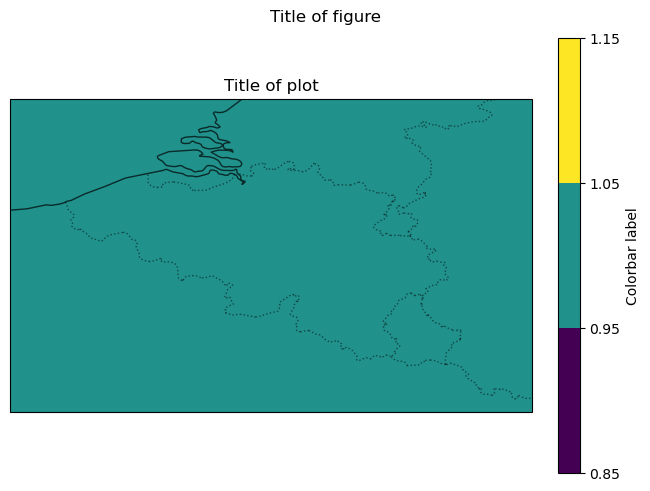

In [7]:
# We define some dummy data with the same dimensions to plot. The data is filled with ones.
# For your plot, you of course have to use the simulation data!
da_dummy = xr.DataArray(data=np.ones((70, 75)), dims=("lat", "lon"), coords={"lon": np.arange(2.0, 7.2, 0.07), "lat": np.arange(49.0, 52.11, 0.045)})

# Change the values of these levels to see what they define
levels = np.arange(0.85, 1.16, 0.1)

# Create a figure. The projection keyword tells matplotlib (and Cartopy) that we are plotting geographical data. The ccrs.PlateCarree() then denotes that the data is in lat-lon format.
fig, ax = plt.subplots(layout="constrained", subplot_kw={"projection" : ccrs.PlateCarree()})
dummy_plot = da_dummy.plot(ax=ax, x="lon", y="lat", levels=levels, add_colorbar=False)

# Add a title to your plot
ax.set_title(f"Title of plot")

# This adds coastlines and borders to the plot.
ax.coastlines(alpha=0.7)
ax.add_feature(cfeature.BORDERS, alpha=0.5, linestyle="dotted")

# This aspect-ratio controls the ratio of the x- and y-axes. Try and find a value which provides a nice picture of our country. (Use the information from above about the spatial resolution and the values in kilometres)
aspect_ratio = 1.0
ax.set_aspect(aspect_ratio)

# Add a color bar and a title to the figure
fig.colorbar(dummy_plot, label="Colorbar label")
fig.suptitle(f"Title of figure", fontsize="large")

# Show the plot!
plt.show()

## Solutions:

We can see on the figure that in large parts of Wallonia more than 100 mm fell over the course of 48 hours. This is comparable to the normal amount of precipitation for the whole month of July! The most extreme part of the event seems to be located in Germany, where in certain points more than 200 mm fell during this period.

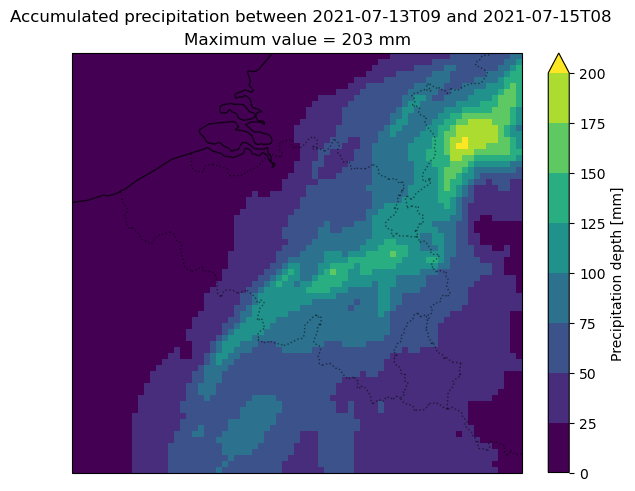

In [8]:
# Select a period out of the the data with tstart and tstop
tstart = "2021-07-13T09"
tstop = "2021-07-15T08"
ds_period = ds.sel(time=slice(tstart, tstop))

# Select the precipitation out of the data and sum over time
pr_period = ds_period.pr
pr_period_sum = pr_period.sum(dim="time")

# Choose levels for the plot
levels = np.arange(0, 201, 25)

# Plot the data
fig, ax = plt.subplots(layout="constrained", subplot_kw={"projection" : ccrs.PlateCarree()})
pr_plot = pr_period_sum.plot(ax=ax, x="lon", y="lat", levels=levels, add_colorbar=False)
# Set the title to show the maximum plotted value
ax.set_title(f"Maximum value = {pr_period_sum.max().values:.0f} mm")

ax.coastlines(alpha=0.7)
ax.add_feature(cfeature.BORDERS, alpha=0.5, linestyle="dotted")

# We found previously that while the resolution in degrees is different for the x- and y-axes, the resolution in kilometres is actually the same. To have this represented on the figure, we should therefore modify the aspect ratio accordingly:
dlat = 0.045
dlon = 0.07
aspect_ratio = dlon / dlat
ax.set_aspect(aspect_ratio)

# We give the color bar and the figure appropriate names
fig.colorbar(pr_plot, label="Precipitation depth [mm]")
fig.suptitle(f"Accumulated precipitation between {tstart} and {tstop}", fontsize="large")

# Show the plot!
plt.show()

# 3. RMI warning levels (WIP, mss wordt dit een extraatje)

We will now consider the severity of the event from a different angle. The Royal Meteorological Institute of Belgium (RMI or KMI in Dutch) issues color-coded warning levels to warn the public about an upcoming extreme events. The colors for these warnings are yellow, orange and red. Warnings exist for all types of events, such as heatwaves, wind and thunder storms, but also for precipitation/rain! Certain thresholds are used by the institute to assign a color to an event. Information about these thresholds can be found on [warnings](https://www.meteo.be/nl/weer/waarschuwingen/weerflashes) (you can change the language in the upper right corner of the page).

Investigate the simulated precipitation during the period between 13 July 2021 08:00 and 15 July 2021 08:00 and determine at which points a yellow/orange/red warning for rain would be issued at any time during this period based on this simulation data. The following functions will probably be helpful for this exercise:
- the `rolling` function: [documentation](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.rolling.html#xarray.DataArray.rolling)
- the `where` function: [documentation](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.where.html#xarray.Dataset.where)

## Solutions:

In [9]:
def mask_pr(pr, color):

    thresholds_dict = {"yellow" : [(1, 20, 30), (6, 20, 40), (24, 25, 50)],
                       "orange" : [(1, 30, 50), (6, 40, 60), (24, 50, 100)], 
                       "red" : [(1, 50, np.inf), (6, 60, np.inf), (24, 100, np.inf)]}

    assert color in thresholds_dict.keys(), "Color not accepted"
    thresholds_list = thresholds_dict[color]

    mask_list = list()

    for idx in range(len(thresholds_list)):
        hours, min_thresh, max_thresh = thresholds_list[idx]

        pr_rolling_sum = pr.rolling(time=hours).sum()
        min_mask = (min_thresh < pr_rolling_sum)
        max_mask = (pr_rolling_sum <= max_thresh)
        mask = (min_mask & max_mask).any("time")

        mask_list.append(mask.assign_coords(idx=idx))

    mask = xr.concat(mask_list, dim="idx").any("idx")
    return pr.where(mask)

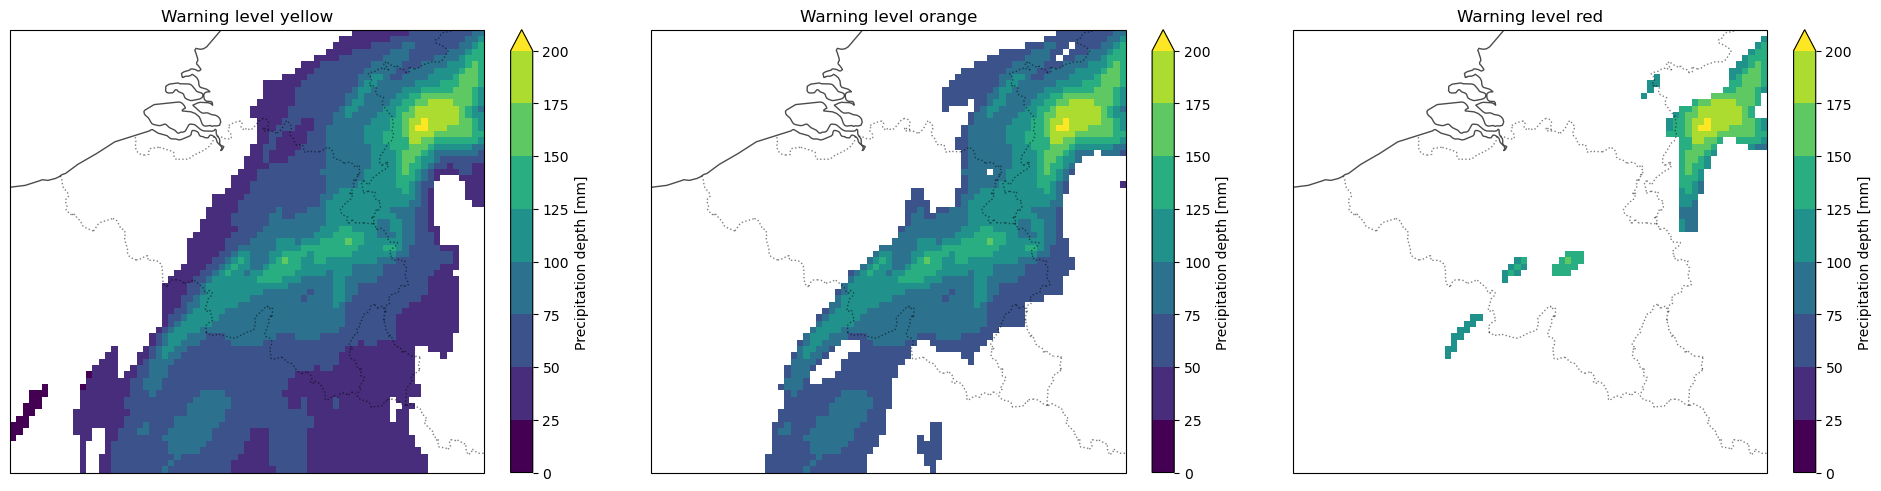

In [10]:
tstart = "2021-07-13T09"
tstop = "2021-07-15T08"
ds_period = ds.sel(time=slice(tstart, tstop))
pr_period = ds_period.pr

fig, axs = plt.subplots(ncols=3, figsize=(19.2, 4.8), layout="constrained", subplot_kw={"projection" : ccrs.PlateCarree()})

for idx in range(3):
    color = ["yellow", "orange", "red"][idx]
    pr_period_masked = mask_pr(pr_period, color)
    pr_period_masked_sum = pr_period_masked.sum("time", skipna=False)

    ax = axs[idx]
    pr_period_masked_sum.plot(ax=ax, levels=np.arange(0, 201, 25), extend="max", cbar_kwargs={"label" : "Precipitation depth [mm]"})
    ax.set_title(f"Warning level {color}")
    ax.coastlines(alpha=0.7)
    ax.add_feature(cfeature.BORDERS, alpha=0.5, linestyle="dotted")
    ax.set_aspect(aspect_ratio)

# 4. Compare with observational gridded data (done!)

We will now compare the simulation data with observational data. As observational data, we take the CLIMATE-GRID dataset of the RMI. This is a gridded dataset with a resolution of 5 km. It contains only daily values. For precipitation, the value on a certain day represent accumulated precipitation between 8:00 on the day in question and 8:00 on the following day. (That is why this period has been chosen for the previous parts of this exercise.) Follow the following steps to compare these observations with the simulation data:
- Load in the CLIMATE-GRID data from the file `CLIMATE_GRID_pr_1951_2023_daily_latlon_5km.nc`. Inspect the attributes of the dataset and of the variable `pr`. Convert the units to $\text{mm}/\text{h}$ (if necessary). How can you relate these values to daily accumulated precipitation (expressed in $\text{mm}$)?
- Select the precipitation data corresponding to the period between 13 July 2021 08:00 and 15 July 2021 08:00 and plot the accumulated precipitation. Use the same color scheme as for the simulation data. What is the maximum value for the observations? When comparing the figures of the simulation and the observations, what differences do you see?
- Compare the simulations directly with the observations by plotting the bias (difference) in accumulated precipitation over this period. What do you see on this figure?
- Calculate and compare the domain-averaged precipitation values. What can you conclude?

## Solutions:

In [20]:
filepath = "../data/CLIMATE_GRID_pr_1951_2023_daily_latlon_5km.nc"
obs_ds = xr.open_dataset(filepath, engine="netcdf4", chunks="auto")
obs_ds = convert_to_mm_h(obs_ds)
obs_ds

<xarray.Dataset>
Dimensions:  (time: 26663, lon: 75, lat: 70)
Coordinates:
  * time     (time) datetime64[ns] 1951-01-01 1951-01-02 ... 2023-12-31
  * lon      (lon) float64 2.0 2.07 2.14 2.21 2.28 ... 6.9 6.97 7.04 7.11 7.18
  * lat      (lat) float64 49.0 49.05 49.09 49.13 ... 51.97 52.02 52.06 52.1
Data variables:
    pr       (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/14)
    CDI:                 Climate Data Interface version 1.9.9 (https://mpimet...
    Conventions:         CF-1.6
    creation_date:       25-06-2024
    creators:            Ghilain N., Van Schaeybroeck B., Vanderkelen I.
    contact:             inne.vanderkelen@meteo.be
    version:             1.1
    ...                  ...
    history:             Tue Jun 25 14:36:40 2024: cdo remapcon,latlon_5km.tx...
    CDO:                 Climate Data Operators version 1.9.9 (https://mpimet...
    freq:                daily
    spatial_resolution:  0.07° x 0.045° (~5km)
    region:              belgium
    dataset:             CLIMATE_GRID

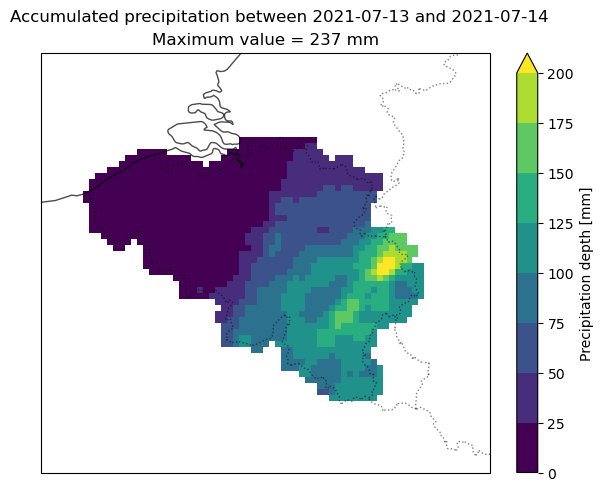

In [12]:
# Select a period out of the the data with tstart and tstop
tstart = "2021-07-13"
tstop = "2021-07-14"
obs_ds_period = obs_ds.sel(time=slice(tstart, tstop))

obs_pr_period = obs_ds_period.pr
obs_pr_period_sum = obs_pr_period.sum("time", skipna=False) * 24

# Choose levels for the plot
levels = np.arange(0, 201, 25)

# Plot the data
fig, ax = plt.subplots(layout="constrained", subplot_kw={"projection" : ccrs.PlateCarree()})
pr_plot = obs_pr_period_sum.plot(ax=ax, x="lon", y="lat", levels=levels, add_colorbar=False, extend="max")
# Set the title to show the maximum plotted value
ax.set_title(f"Maximum value = {obs_pr_period_sum.max().values:.0f} mm")

ax.coastlines(alpha=0.7)
ax.add_feature(cfeature.BORDERS, alpha=0.5, linestyle="dotted")

# We found previously that while the resolution in degrees is different for the x- and y-axes, the resolution in kilometres is actually the same. To have this represented on the figure, we should therefore modify the aspect ratio accordingly:
dlat = 0.045
dlon = 0.07
aspect_ratio = dlon / dlat
ax.set_aspect(aspect_ratio)

# We give the color bar and the figure appropriate names
fig.colorbar(pr_plot, label="Precipitation depth [mm]")
fig.suptitle(f"Accumulated precipitation between {tstart} and {tstop}", fontsize="large")

# Show the plot!
plt.show()

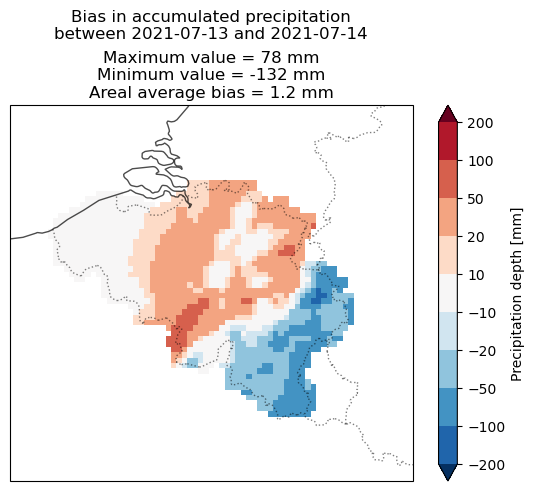

In [13]:
# Select a period out of the the data with tstart and tstop
tstart = "2021-07-13T09"
tstop = "2021-07-15T08"
ds_period = ds.sel(time=slice(tstart, tstop))
pr_period = ds_period.pr
pr_period_sum = pr_period.sum(dim="time")

# Select a period out of the the data with tstart and tstop
tstart = "2021-07-13"
tstop = "2021-07-14"
obs_ds_period = obs_ds.sel(time=slice(tstart, tstop))
obs_pr_period = obs_ds_period.pr
obs_pr_period_sum = obs_pr_period.sum("time", skipna=False) * 24

# Calculate bias/difference
bias_period_sum = pr_period_sum - obs_pr_period_sum

# Choose levels for the plot
levels = [-200, -100, -50, -20, -10, 10, 20, 50, 100, 200]

# Plot the data
fig, ax = plt.subplots(layout="constrained", subplot_kw={"projection" : ccrs.PlateCarree()})
pr_plot = bias_period_sum.plot(ax=ax, x="lon", y="lat", levels=levels, add_colorbar=False, extend="both")
ax.set_title(f"Maximum value = {bias_period_sum.max().values:.0f} mm\nMinimum value = {bias_period_sum.min().values:.0f} mm\nAreal average bias = {bias_period_sum.mean().values:.1f} mm")
ax.coastlines(alpha=0.7)
ax.add_feature(cfeature.BORDERS, alpha=0.5, linestyle="dotted")

dlat = 0.045
dlon = 0.07
aspect_ratio = dlon / dlat
ax.set_aspect(aspect_ratio)

fig.colorbar(pr_plot, label="Precipitation depth [mm]")
fig.suptitle(f"Bias in accumulated precipitation\nbetween {tstart} and {tstop}", fontsize="large")
plt.show()

From the plotted bias in accumulated precipitation we can see that there are locations with large biases over Belgium. In the Northern part of the country the simulation mostly overestimates the precipitation, while in the South it is underestimated. However, when calculating the areal average of the bias, we can see that the difference between model and observations is relatively small. Therefore, we can conclucde that the model does simulate the event correctly, but the event is located too much to the North.

# 5. Compare with observational station data (done!)

We will now take a look at some time series data of the event. For this exercise, you will use station measurements from five stations which measured the highest precipitation amounts during the Vesder event. These station data contain hourly values, contrary to the daily CLIMATE-GRID data. 

- Load in the station data for the five stations from the file `SETHY_pr_2021-07-12T01_2021-07-17T00.nc`. Inspect the structure of this Dataset. Convert (as usual) the precipitation data to $\text{mm}/\text{h}$, if necessary. 
- Make a plot of the locations of the stations on a map. You can use the function `.plot.scatter()`, which you can apply to a Dataset. This function accepts arguments `x` and `y`, which tell the function which Dataset variables/coordinates to use as x- and y-values for the plot. Where are the five stations located? Does it make sense that these stations received the highest precipitation amounts in light of the CLIMATE-GRID data (use your previous plots!)?
- For each of the five stations, plot the time series of hourly precipitation flux. Also, make a plot of the cumulative precipitation amount over time. What can you conclude when comparing these station observations to the simulated data? Is this in line with previous conclusions? 
- Finally, compare the stations measurements to the CLIMATE-GRID data. What do you see?

## Solutions:

In [14]:
# Open the station data
ds_stations = xr.open_dataset("../data/SETHY_pr_2021-07-12T01_2021-07-17T00.nc", engine="netcdf4", chunks="auto")
ds_stations

<xarray.Dataset>
Dimensions:   (time: 120, location: 5)
Coordinates:
    index     (time) int64 dask.array<chunksize=(120,), meta=np.ndarray>
    year      (time) int64 dask.array<chunksize=(120,), meta=np.ndarray>
    month     (time) int64 dask.array<chunksize=(120,), meta=np.ndarray>
    day       (time) int64 dask.array<chunksize=(120,), meta=np.ndarray>
    hour      (time) int64 dask.array<chunksize=(120,), meta=np.ndarray>
  * time      (time) datetime64[ns] 2021-07-12T01:00:00 ... 2021-07-17
  * location  (location) <U12 'Jalhay' 'Spa' 'Mont-Rigi' 'Neu-Hattlich' 'Erezee'
    lon       (location) float64 dask.array<chunksize=(5,), meta=np.ndarray>
    lat       (location) float64 dask.array<chunksize=(5,), meta=np.ndarray>
Data variables:
    pr        (location, time) float64 dask.array<chunksize=(5, 120), meta=np.ndarray>
Attributes:
    standard_name:  precipitation_flux
    long_name:      Precipitation
    units:          mm/h
    cell_methods:   time: mean

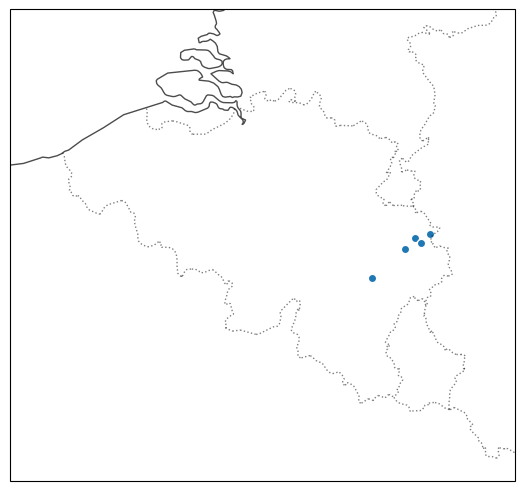

In [15]:
# Plot the locations of the stations
fig, ax = plt.subplots(layout="constrained", subplot_kw={"projection": ccrs.PlateCarree()})
ds_stations.plot.scatter(ax=ax, x="lon", y="lat")
ax.coastlines(alpha=0.7)
ax.add_feature(cfeature.BORDERS, alpha=0.5, linestyle="dotted")
ax.set_aspect(aspect_ratio)
ax.set_xlim(2, 7)
ax.set_ylim(49, 52)
plt.show()

When looking at the plot of acummulated precipitation from CLIMATE-GRID, we see that these stations lie in the region with the highest amount of rainfall during this period.

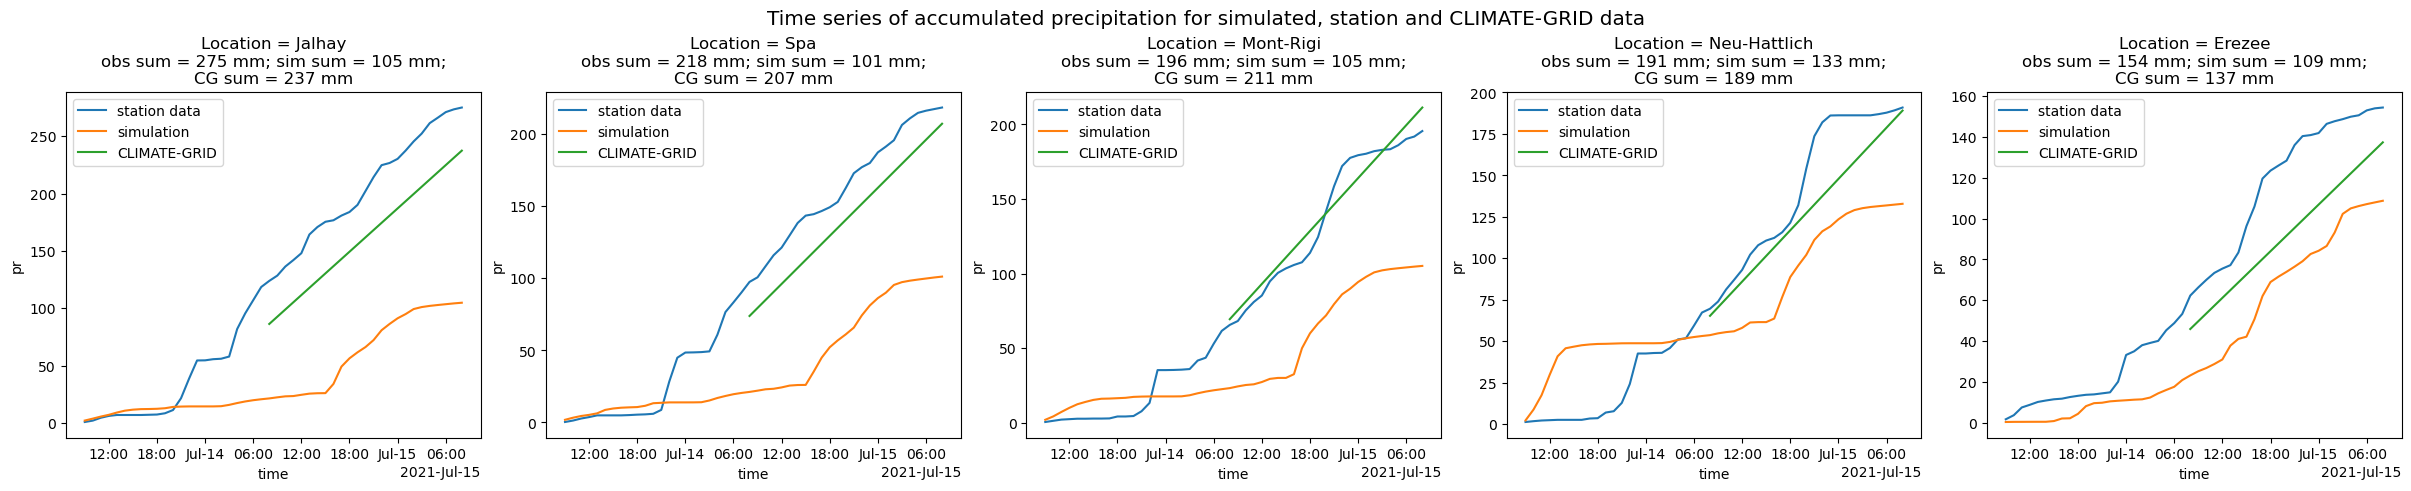

In [16]:
tstart = "2021-07-13T09"
tstop = "2021-07-15T08"
ds_period = ds.sel(time=slice(tstart, tstop))
ds_stations_period = ds_stations.sel(time=slice(tstart, tstop))

obs_mask = ~obs_ds_period.isnull().any("time")
obs_cumsum = obs_ds_period.mean(["lat", "lon"]).cumsum(dim="time") * 24
obs_cumsum = obs_cumsum.assign_coords(time=obs_ds_period.time)
obs_cumsum = obs_cumsum.assign_coords(time=obs_cumsum.time + np.timedelta64(32, "h"))
obs_cumsum.time

cumulative = True

nloc = len(ds_stations.location)

fig, axs = plt.subplots(ncols=5, figsize=(4.8 * nloc, 4.8), layout="constrained")

for idx in range(nloc):
    location = ds_stations.location[idx]
    lon, lat = ds_stations.lon[idx], ds_stations.lat[idx]

    ax = axs[idx]
    ds_location = ds_period.sel(lon=lon, lat=lat, method="nearest")
    obs_location = obs_ds_period.sel(lon=lon, lat=lat, method="nearest")
    obs_location = obs_location.assign_coords(time=obs_ds_period.time + np.timedelta64(32, "h"))

    if cumulative:
        ds_stations_period.sel(location=location).pr.cumsum().plot(ax=ax, label="station data")
        ds_location.pr.cumsum().plot(ax=ax, label="simulation")
        (obs_location.pr.cumsum() * 24).plot(ax=ax, x="time", label="CLIMATE-GRID")
    else:
        ds_stations_period.sel(location=location).pr.plot(ax=ax, label="station data")
        ds_location.pr.plot(ax=ax, label="simulation")

    station_sum = ds_stations_period.sel(location=location).pr.sum().values
    sim_sum = ds_location.pr.sum().values
    obs_sum = obs_location.pr.sum().values * 24

    ax.set_title(f"Location = {location.values}\nobs sum = {station_sum:.0f} mm; sim sum = {sim_sum:.0f} mm;\nCG sum = {obs_sum:.0f} mm")
    ax.legend()

if cumulative:
    fig.suptitle("Time series of accumulated precipitation for simulated, station and CLIMATE-GRID data", fontsize="x-large")
else:
    fig.suptitle("Time series of precipitation for simulated and station data", fontsize="x-large")

When comparing the simulation with the station measurements, we see that the measured rainfall significantly exceeds the simulated amounts at these locations. The station data also generally give even higher rainfall amounts than the CLIMATE-GRID dataset.

# 6./Extra. Work with ensemble data (done)

*Not sure if adding this exercise adds value*

**Add some explanation about ensembles.**

- Load in an ensemble created by running simulations with a different start time.
- Calculate the bias of the domain-averaged accumulated precipitation during the period between 13 July 2021 08:00 and 15 July 2021 08:00 for each memeber of the ensemble compared to the CLIMATE-GRID data. Repeat this exercise but for the two 24-hour periods inside of this 48-hour period. What can you conclude?
- Plot the ensemble data for each of the station locations. What do you see?

## Solutions:

In [17]:
run_name = "baseline"
run_info_list = [("2021070100", 384), 
                 ("2021070112", 372), 
                 ("2021070200", 360),
                 ("2021070212", 348),
                 ("2021070300", 336), 
                 ("2021070312", 324), 
                 ("2021070400", 312)]

ds_ens_list = list()

for run_info in run_info_list:
    rstart, nhours = run_info
    filepath = f"../data/{run_name}_{rstart}_{nhours}_pr_*.nc"
    ds_ens = xr.open_mfdataset(filepath, engine="netcdf4", chunks="auto")
    ds_ens_list.append(ds_ens)

ds_ens = xr.concat(ds_ens_list, dim="rstart")
ds_ens = convert_to_mm_h(ds_ens)
ds_ens.load()

<xarray.Dataset>
Dimensions:    (time: 384, lon: 75, lat: 70, rstart: 7, bnds: 2)
Coordinates:
  * time       (time) datetime64[ns] 2021-07-01T01:00:00 ... 2021-07-17
  * lon        (lon) float64 2.0 2.07 2.14 2.21 2.28 ... 6.9 6.97 7.04 7.11 7.18
  * lat        (lat) float64 49.0 49.05 49.09 49.13 ... 51.97 52.02 52.06 52.1
    time_bnds  (rstart, time, bnds) datetime64[ns] 2021-07-01 ... 2021-07-17
    crs        int64 0
  * rstart     (rstart) <U10 '2021070100' '2021070112' ... '2021070400'
    run_name   <U8 'baseline'
Dimensions without coordinates: bnds
Data variables:
    pr         (rstart, time, lat, lon) float32 0.0 0.0 ... 0.0006729 0.001137
Attributes: (12/33)
    CDI:                       Climate Data Interface version 2.0.6 (https://...
    source:                    ALARO-1 (CY43T2) - SURFEX v8.0
    Conventions:               CF-1.11
    activity_id:               DD
    comment:                   
    contact:                   wout.dewettinck@ugent.be
    ...                        ...
    version_realization_info:  
    creation_date:             2024-10-30T10:33:47Z
    frequency:                 1hr
    StartTime:                 2021-07-01T00:00
    EndTime:                   2021-07-17T00:00
    CDO:                       Climate Data Operators version 2.0.6 (https://...

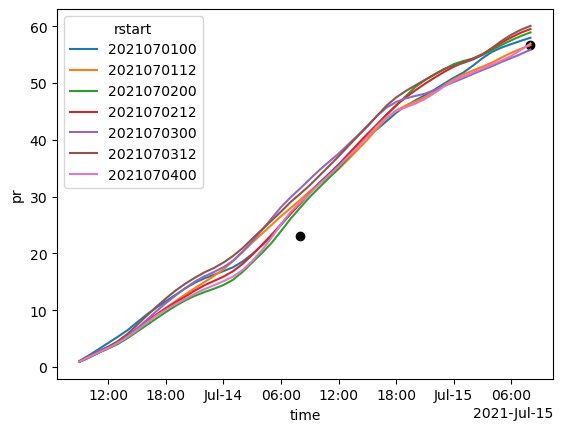

In [18]:
tstart = "2021-07-13T09"
tstop = "2021-07-15T08"
ds_ens_period = ds_ens.sel(time=slice(tstart, tstop))
pr_ens_period = ds_ens_period.pr

tstart = "2021-07-13"
tstop = "2021-07-14"
obs_ds_period = obs_ds.sel(time=slice(tstart, tstop))
obs_pr_period = obs_ds_period.pr

obs_mask = ~obs_ds_period.isnull().any("time")
pr_ens_period_cumsum = pr_ens_period.cumsum(dim="time").where(obs_mask.pr).mean(["lat", "lon"])
pr_ens_period_cumsum.plot(x="time", hue="rstart")
obs_pr_period_cumsum = obs_pr_period.mean(["lat", "lon"]).cumsum(dim="time").assign_coords(time=obs_ds_period.time + np.timedelta64(32, "h")) * 24
obs_pr_period_cumsum.plot.scatter(x="time", color="black")

While the 48-hour accumulated precipitation amounts averaged over Belgium are well represented by the ensemble, this is not the case for the two 24-hour periods. For the first 24 hours, the precipitation is overestimated by the ensemble, which is compensated by an underestimation during the second 24 hours.

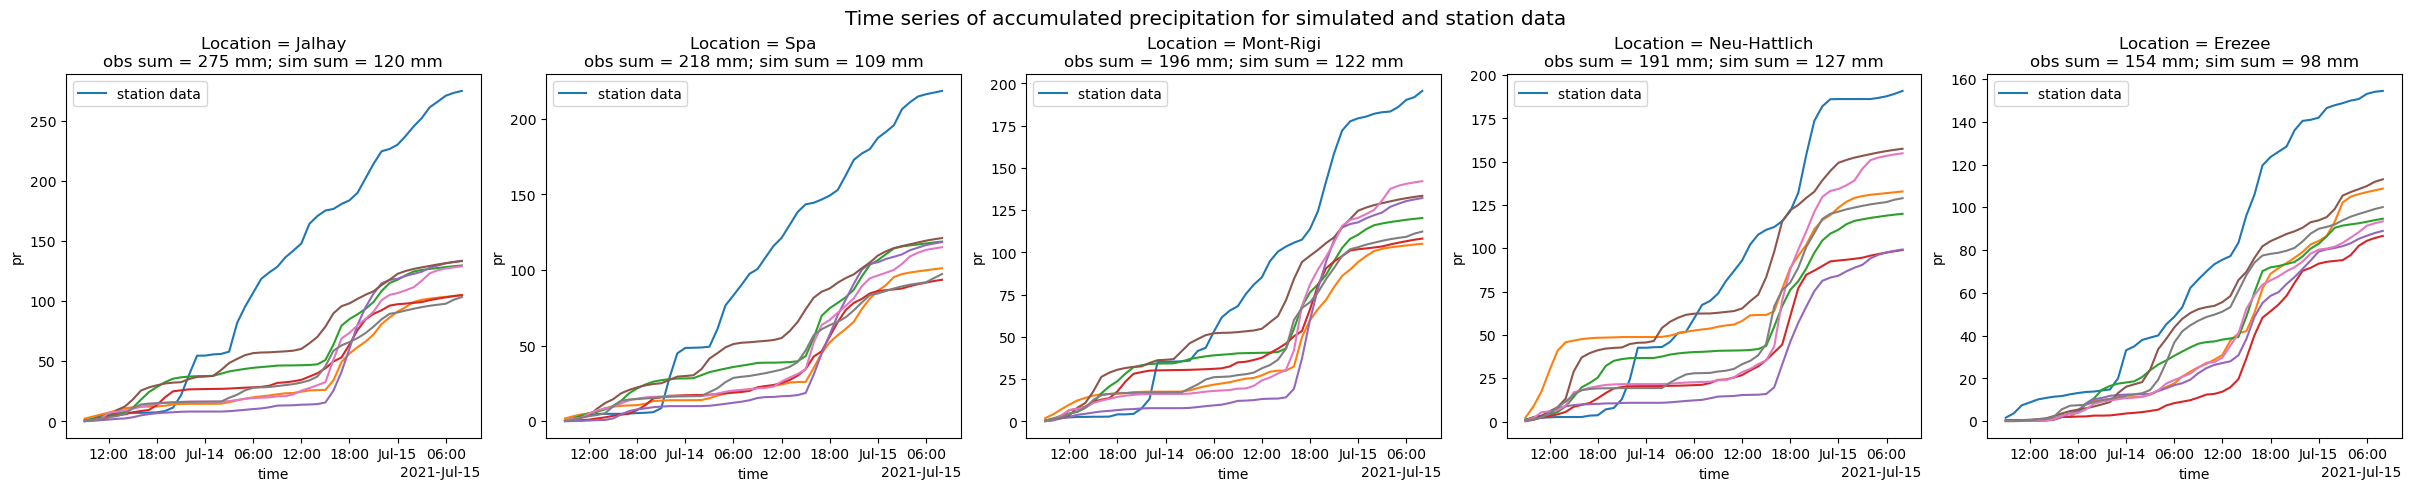

In [19]:
tstart = "2021-07-13T09"
tstop = "2021-07-15T08"
ds_ens_period = ds_ens.sel(time=slice(tstart, tstop))
ds_stations_period = ds_stations.sel(time=slice(tstart, tstop))

cumulative = True

nloc = len(ds_stations.location)

fig, axs = plt.subplots(ncols=5, figsize=(4.8 * nloc, 4.8), layout="constrained")

for idx in range(nloc):
    location = ds_stations.location[idx]
    lon, lat = ds_stations.lon[idx], ds_stations.lat[idx]

    ax = axs[idx]
    ds_ens_location = ds_ens_period.sel(lon=lon, lat=lat, method="nearest")
    obs_location = obs_ds_period.sel(lon=lon, lat=lat, method="nearest")
    obs_location = obs_location.assign_coords(time=obs_ds_period.time + np.timedelta64(32, "h"))

    if cumulative:
        ds_stations_period.sel(location=location).pr.cumsum(dim="time").plot(ax=ax, label="station data")
        ds_ens_location.pr.cumsum(dim="time").plot(ax=ax, hue="rstart")
    else:
        ds_stations_period.sel(location=location).pr.plot(ax=ax, label="station data")
        ds_ens_location.pr.plot(ax=ax, hue="rstart")

    station_sum = ds_stations_period.sel(location=location).pr.sum().values
    sim_sum = ds_ens_location.pr.sum(dim="time").mean(dim="rstart").values

    ax.set_title(f"Location = {location.values}\nobs sum = {station_sum:.0f} mm; sim sum = {sim_sum:.0f} mm")
    ax.legend()

if cumulative:
    fig.suptitle("Time series of accumulated precipitation for simulated and station data", fontsize="x-large")
else:
    fig.suptitle("Time series of precipitation for simulated and station data", fontsize="x-large")

All simulations of the ensemble underestime the observed rainfall amount during this period. At some locations the spread of the ensemble is quite large.